# Convolutional Neural Network to achieve hand-written digit recognition

### Libraries Required

In [1]:
import torch
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

### Defining Hyperparameters

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

number_of_epochs = 10
number_of_classes = 10
batch_size_train = 100
batch_size_test = 1000
learning_rate = 1e-3
momentum = 0.5
log_interval = 10

random_seed = 1
torch.manual_seed(random_seed)

cuda


### Obtaining Data from MNIST database

In [3]:
"""

root (string) – Root directory of dataset where MNIST/processed/training.pt and MNIST/processed/test.pt exist.

train (bool, optional) – If True, creates dataset from training.pt, otherwise from test.pt.

download (bool, optional) – If true, downloads the dataset from the internet and puts it in root directory. If dataset is already downloaded, it is not downloaded again.

transform (callable, optional) – A function/transform that takes in an PIL image and returns a transformed version. E.g, transforms.ToTensor()

transforms.Compose([]) is used to club all the transforms provided to it which are applied to the input one by one.

transforms.ToTensor(): This just converts your input image to PyTorch tensor

"""
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.1307,), (0.3081,))])

training_data = datasets.MNIST("MNIST",train = True, download = True, transform = transform)

testing_data = datasets.MNIST("MNIST",train = False, download = True, transform = transform)

100.1%

Extracting MNIST\MNIST\raw\train-images-idx3-ubyte.gz to MNIST\MNIST\raw


113.5%

Extracting MNIST\MNIST\raw\train-labels-idx1-ubyte.gz to MNIST\MNIST\raw

6.0%

100.4%

Extracting MNIST\MNIST\raw\t10k-images-idx3-ubyte.gz to MNIST\MNIST\raw


180.4%

Extracting MNIST\MNIST\raw\t10k-labels-idx1-ubyte.gz to MNIST\MNIST\raw
Processing...
Done!


### Creating Training and Testing datasets

In [4]:
'''
train = loading data from Train dataset

test = loading data from Test dataset

batch_size (python:int, optional) – how many samples per batch to load.

shuffle (bool, optional) – set to True to have the data reshuffled at every epoch (default: False).
'''

trainset = torch.utils.data.DataLoader(training_data, batch_size = batch_size_train, shuffle = True)
testset = torch.utils.data.DataLoader(testing_data, batch_size = batch_size_test, shuffle = True)

In [5]:
# Checking out how the training data looks in a pytorch Tensor
print("Number of images in Training dataset = ", len(training_data))
print("Number of images in Test dataset = ",len(testing_data))
for training_data in trainset:
    print(training_data)
    break

Number of images in Training dataset =  60000
Number of images in Test dataset =  10000
[tensor([[[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [

In [6]:
# Checking the labels
sampledata = iter(trainset)
images, labels = sampledata.next()

In [7]:
#Checking the size of Image Tensor
print("Shape of the images",images.shape)
print("Shape of the labels",labels.shape)

Shape of the images torch.Size([100, 1, 28, 28])
Shape of the labels torch.Size([100])


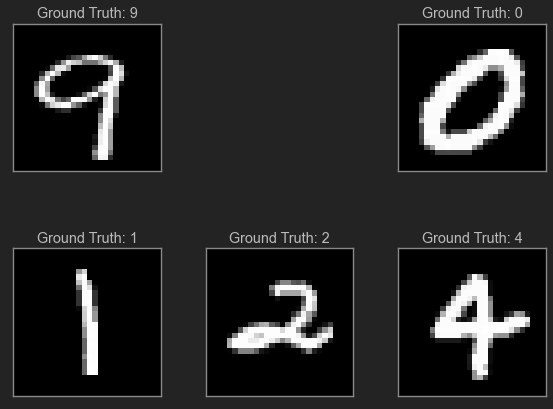

In [8]:
# Printing a sample of Training dataset images
# fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(training_data[0][i].view(28,28), cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(training_data[1][i]))
    plt.xticks([])
    plt.yticks([])
#     fig

In [9]:
# Finding out how much each class contibutes in the training data set
total = 0
counter_dict = {0:0, 1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0,9:0}

for training_data in trainset:
    Num_images,Num_labels = training_data
    for y in Num_labels:
        counter_dict[int(y)] += 1
        total += 1
print(counter_dict)

for i in counter_dict:
    print(f"{i}: {np.round(counter_dict[i]/total*100, 4)} %")

{0: 5923, 1: 6742, 2: 5958, 3: 6131, 4: 5842, 5: 5421, 6: 5918, 7: 6265, 8: 5851, 9: 5949}
0: 9.8717 %
1: 11.2367 %
2: 9.93 %
3: 10.2183 %
4: 9.7367 %
5: 9.035 %
6: 9.8633 %
7: 10.4417 %
8: 9.7517 %
9: 9.915 %


### Creating the Neural Network

In [10]:
import torch.optim as optim

class MNISTNET(nn.Module):
    def __init__(self, num_classes=number_of_classes):
        super(MNISTNET, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

model = MNISTNET(number_of_classes).to(device)

# Loss and optimizer
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                      momentum=momentum)

### Function for training the model

In [11]:
training_losses = []
training_counter = []

In [12]:
def training(epoch):
    model.train()
    for i, (images, labels) in enumerate(trainset):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # Forward pass
        outputs = model(images)
        loss = F.nll_loss(outputs, labels)
        # Backward and optimize
        loss.backward()
        optimizer.step()
        
        if i % log_interval == 0:
            print ('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}' .format
                   (epoch+1, i * len(images), len(trainset.dataset),
                    100. * i / len(trainset), loss.item()))
            
            training_losses.append(loss.item())
            training_counter.append((i*100) + ((epoch-1)*len(trainset.dataset)))

In [13]:
def testing():
    model.eval()
    correct = 0    
    with torch.no_grad():
        
        for images, labels in testset:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            test_loss += F.nll_loss(outputs, labels,size_average=False).item()
            _, predicted = torch.max(outputs.data, 1)
            correct +=  predicted.eq(labels.data.view_as(predicted)).sum()

    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(testset.dataset),
        100. * correct / len(testset.dataset)))

### Training and Testing the Model

In [14]:
%time
testing()
for epoch in range(10):
    training(epoch)
    testing()

Wall time: 1 ms


<ipython-input-10-2bfd4984378a>:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
C:\Users\super\anaconda3\envs\project_gpu\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.2340, Accuracy: 563/10000 (6%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.365737
Train Epoch: 1 [1000/60000 (2%)]	Loss: 2.343523
Train Epoch: 1 [2000/60000 (3%)]	Loss: 2.298751
Train Epoch: 1 [3000/60000 (5%)]	Loss: 2.352094
Train Epoch: 1 [4000/60000 (7%)]	Loss: 2.336951
Train Epoch: 1 [5000/60000 (8%)]	Loss: 2.338910
Train Epoch: 1 [6000/60000 (10%)]	Loss: 2.337193
Train Epoch: 1 [7000/60000 (12%)]	Loss: 2.325987
Train Epoch: 1 [8000/60000 (13%)]	Loss: 2.318565
Train Epoch: 1 [9000/60000 (15%)]	Loss: 2.320380
Train Epoch: 1 [10000/60000 (17%)]	Loss: 2.335034
Train Epoch: 1 [11000/60000 (18%)]	Loss: 2.305433
Train Epoch: 1 [12000/60000 (20%)]	Loss: 2.312595
Train Epoch: 1 [13000/60000 (22%)]	Loss: 2.317094
Train Epoch: 1 [14000/60000 (23%)]	Loss: 2.300111
Train Epoch: 1 [15000/60000 (25%)]	Loss: 2.306907
Train Epoch: 1 [16000/60000 (27%)]	Loss: 2.302980
Train Epoch: 1 [17000/60000 (28%)]	Loss: 2.282630
Train Epoch: 1 [18000/60000 (30%)]	Loss: 2.322741
Train Epoch: 

Train Epoch: 3 [42000/60000 (70%)]	Loss: 1.389557
Train Epoch: 3 [43000/60000 (72%)]	Loss: 1.342927
Train Epoch: 3 [44000/60000 (73%)]	Loss: 1.235379
Train Epoch: 3 [45000/60000 (75%)]	Loss: 1.426541
Train Epoch: 3 [46000/60000 (77%)]	Loss: 1.399778
Train Epoch: 3 [47000/60000 (78%)]	Loss: 1.407992
Train Epoch: 3 [48000/60000 (80%)]	Loss: 1.334120
Train Epoch: 3 [49000/60000 (82%)]	Loss: 1.346608
Train Epoch: 3 [50000/60000 (83%)]	Loss: 1.314066
Train Epoch: 3 [51000/60000 (85%)]	Loss: 1.430705
Train Epoch: 3 [52000/60000 (87%)]	Loss: 1.497975
Train Epoch: 3 [53000/60000 (88%)]	Loss: 1.239921
Train Epoch: 3 [54000/60000 (90%)]	Loss: 1.365178
Train Epoch: 3 [55000/60000 (92%)]	Loss: 1.298238
Train Epoch: 3 [56000/60000 (93%)]	Loss: 1.158019
Train Epoch: 3 [57000/60000 (95%)]	Loss: 1.325263
Train Epoch: 3 [58000/60000 (97%)]	Loss: 1.213341
Train Epoch: 3 [59000/60000 (98%)]	Loss: 1.311278

Test set: Avg. loss: 0.0858, Accuracy: 8296/10000 (83%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 1.4156

Train Epoch: 6 [24000/60000 (40%)]	Loss: 0.647414
Train Epoch: 6 [25000/60000 (42%)]	Loss: 0.691942
Train Epoch: 6 [26000/60000 (43%)]	Loss: 0.695905
Train Epoch: 6 [27000/60000 (45%)]	Loss: 0.695993
Train Epoch: 6 [28000/60000 (47%)]	Loss: 0.823648
Train Epoch: 6 [29000/60000 (48%)]	Loss: 0.831594
Train Epoch: 6 [30000/60000 (50%)]	Loss: 0.918558
Train Epoch: 6 [31000/60000 (52%)]	Loss: 0.783041
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.732551
Train Epoch: 6 [33000/60000 (55%)]	Loss: 0.944562
Train Epoch: 6 [34000/60000 (57%)]	Loss: 0.772490
Train Epoch: 6 [35000/60000 (58%)]	Loss: 0.827804
Train Epoch: 6 [36000/60000 (60%)]	Loss: 0.507287
Train Epoch: 6 [37000/60000 (62%)]	Loss: 0.571393
Train Epoch: 6 [38000/60000 (63%)]	Loss: 0.884444
Train Epoch: 6 [39000/60000 (65%)]	Loss: 0.844814
Train Epoch: 6 [40000/60000 (67%)]	Loss: 0.703810
Train Epoch: 6 [41000/60000 (68%)]	Loss: 0.731690
Train Epoch: 6 [42000/60000 (70%)]	Loss: 0.793105
Train Epoch: 6 [43000/60000 (72%)]	Loss: 0.757237


Train Epoch: 9 [6000/60000 (10%)]	Loss: 0.487726
Train Epoch: 9 [7000/60000 (12%)]	Loss: 0.690525
Train Epoch: 9 [8000/60000 (13%)]	Loss: 0.651560
Train Epoch: 9 [9000/60000 (15%)]	Loss: 0.395198
Train Epoch: 9 [10000/60000 (17%)]	Loss: 0.506579
Train Epoch: 9 [11000/60000 (18%)]	Loss: 0.632571
Train Epoch: 9 [12000/60000 (20%)]	Loss: 0.493817
Train Epoch: 9 [13000/60000 (22%)]	Loss: 0.644500
Train Epoch: 9 [14000/60000 (23%)]	Loss: 0.501499
Train Epoch: 9 [15000/60000 (25%)]	Loss: 0.612763
Train Epoch: 9 [16000/60000 (27%)]	Loss: 0.501482
Train Epoch: 9 [17000/60000 (28%)]	Loss: 0.391802
Train Epoch: 9 [18000/60000 (30%)]	Loss: 0.744198
Train Epoch: 9 [19000/60000 (32%)]	Loss: 0.589290
Train Epoch: 9 [20000/60000 (33%)]	Loss: 0.637953
Train Epoch: 9 [21000/60000 (35%)]	Loss: 0.527003
Train Epoch: 9 [22000/60000 (37%)]	Loss: 0.564314
Train Epoch: 9 [23000/60000 (38%)]	Loss: 0.538483
Train Epoch: 9 [24000/60000 (40%)]	Loss: 0.665042
Train Epoch: 9 [25000/60000 (42%)]	Loss: 0.465131
Trai

### Evaluating the Performance of the Model

Text(0, 0.5, 'negative log likelihood loss')

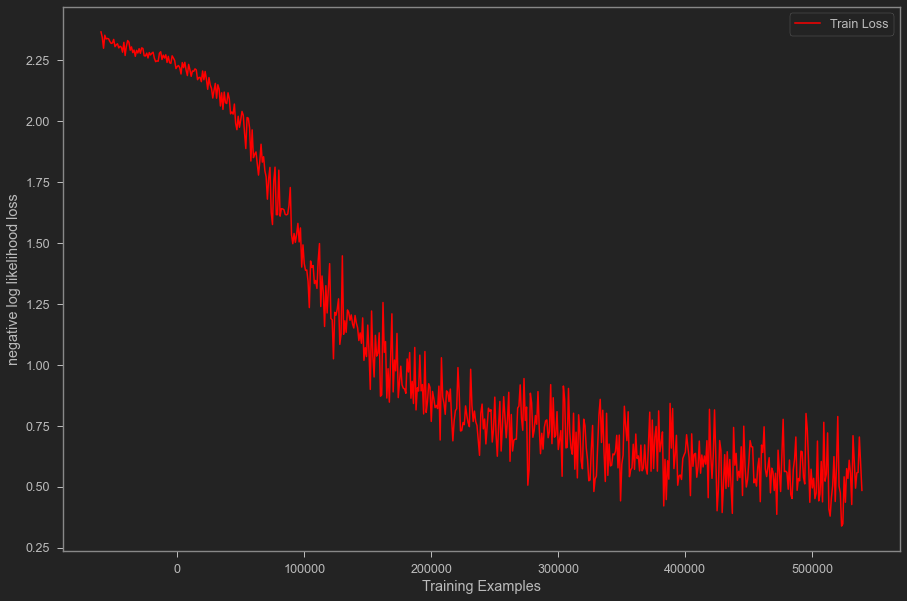

In [15]:
plt.figure(figsize=(15, 10))
plt.tight_layout()
plt.plot(training_counter, training_losses, color='red')
plt.legend(['Train Loss'], loc='upper right')
plt.xlabel('Training Examples')
plt.ylabel('negative log likelihood loss')